<a href="https://colab.research.google.com/github/Saumyen10/Quantacus_Assignment/blob/main/Quantacus_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Email Campaign Analysis

In [35]:
##import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Load datasets
email_df = pd.read_csv('email_table.csv')
email_opened_df = pd.read_csv('email_opened_table.csv')
link_clicked_df = pd.read_csv('link_clicked_table.csv')

In [37]:
email_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [38]:
print(len(email_df))
print(len(email_opened_df))
len(link_clicked_df)

100000
10345


2119

From a total of 100000 emails sent to people, 10345 people opened it and from that 2119 people clicked on the link in that email.

In [39]:
print("Percentage of people opened the email:", round((len(email_opened_df)/len(email_df))*100,2),"%")
print("Percentage of people that clicked the link:", round((len(link_clicked_df)/len(email_opened_df))*100,2),"%")

Percentage of people opened the email: 10.35 %
Percentage of people that clicked the link: 20.48 %


In [40]:
#create 2 new columns which represents whether each email was opened or clicked

email_df["opened"] = email_df["email_id"].isin(email_opened_df["email_id"]).astype(int)
email_df["clicked"] = email_df["email_id"].isin(link_clicked_df["email_id"]).astype(int)

In [41]:
email_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


opened/clicked:  

  True(1), False(0)

In [42]:
total_emails = len(email_df)
total_emails_opened = email_df["opened"].sum()
total_links_clicked = email_df["clicked"].sum()

In [43]:
print("Total emails sent:", total_emails)
print("Total emails opened:", total_emails_opened)
print("Total links clicked:", total_links_clicked)

Total emails sent: 100000
Total emails opened: 10345
Total links clicked: 2119


In [44]:
open_rate = total_emails_opened / total_emails
click_through_rate = total_links_clicked / total_emails
click_to_open_rate = total_links_clicked / total_emails_opened

print(f"Open Rate: {open_rate:.2%}")
print(f"Click-Through Rate: {click_through_rate:.2%}")
print(f"Click-to-Open Rate: {click_to_open_rate:.2%}\n")

Open Rate: 10.35%
Click-Through Rate: 2.12%
Click-to-Open Rate: 20.48%



##using Random Forest Classifier

In [45]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder        #converts text labels -> numbers

label_cols = ["email_text", "email_version", "weekday", "user_country"]    #the following columns values will be converted into numbers
email_df_encoded = email_df.copy()
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    email_df_encoded[col] = le.fit_transform(email_df[col])
    le_dict[col] = le

**LabelEnocoder** : is used to convert the text(**categorical**)values into numbers

For e.g.:  in email_text:
            
  short_email" → 0, "long_email" → 1

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [47]:
# Features and target
input = ["email_text", "email_version", "hour", "weekday", "user_country", "user_past_purchases"]
X = email_df_encoded[input]
y = email_df_encoded["clicked"]    #clicked: yes->1, no->0

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#training the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [48]:
len(X_test)

30000

In [49]:
#predict
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [51]:
#evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}\n")

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     29364
           1       0.07      0.01      0.02       636

    accuracy                           0.98     30000
   macro avg       0.52      0.50      0.50     30000
weighted avg       0.96      0.98      0.97     30000

Confusion Matrix:
 [[29278    86]
 [  630     6]]
ROC AUC Score: 0.5892



In [52]:
# Simulate optimized campaign: Target top 10% highest predicted click probabilities
X_test_copy = X_test.copy()
X_test_copy["pred_prob"] = y_pred_prob
threshold = X_test_copy["pred_prob"].quantile(0.9)
top_segment = X_test_copy[X_test_copy["pred_prob"] >= threshold]

optimized_ctr = y_test[top_segment.index].sum() / len(top_segment)
print(f"Simulated Optimized CTR (Top 10%) using Random Forest: {optimized_ctr:.2%}")
print(f"Original CTR: {click_through_rate:.2%}")
print(f"Estimated Improvement: {(optimized_ctr / click_through_rate):.2f}x\n")

Simulated Optimized CTR (Top 10%) using Random Forest: 4.03%
Original CTR: 2.12%
Estimated Improvement: 1.90x



In [53]:
# Simulate optimized campaign: Target top 20% highest predicted click probabilities
X_test_copy = X_test.copy()
X_test_copy["pred_prob"] = y_pred_prob
threshold = X_test_copy["pred_prob"].quantile(0.8)
top_segment = X_test_copy[X_test_copy["pred_prob"] >= threshold]

optimized_ctr = y_test[top_segment.index].sum() / len(top_segment)
print(f"Simulated Optimized CTR (Top 20%) using Random Forest: {optimized_ctr:.2%}")
print(f"Original CTR: {click_through_rate:.2%}")
print(f"Estimated Improvement: {(optimized_ctr / click_through_rate):.2f}x\n")

Simulated Optimized CTR (Top 20%) using Random Forest: 3.77%
Original CTR: 2.12%
Estimated Improvement: 1.78x



In [54]:
# Simulate optimized campaign: Target top 30% highest predicted click probabilities
X_test_copy = X_test.copy()
X_test_copy["pred_prob"] = y_pred_prob
threshold = X_test_copy["pred_prob"].quantile(0.7)
top_segment = X_test_copy[X_test_copy["pred_prob"] >= threshold]

optimized_ctr = y_test[top_segment.index].sum() / len(top_segment)
print(f"Simulated Optimized CTR (Top 30%) using Random Forest: {optimized_ctr:.2%}")
print(f"Original CTR: {click_through_rate:.2%}")
print(f"Estimated Improvement: {(optimized_ctr / click_through_rate):.2f}x\n")

Simulated Optimized CTR (Top 30%) using Random Forest: 2.12%
Original CTR: 2.12%
Estimated Improvement: 1.00x



In [55]:
# Segment analysis example: CTR by email version and text
segment_summary = email_df.groupby(["email_text", "email_version"])["clicked"].mean().reset_index()
segment_summary.columns = ["email_text", "email_version", "CTR"]
print("CTR by Email Text and Version:\n")
print(segment_summary)

CTR by Email Text and Version:

    email_text email_version       CTR
0   long_email       generic  0.013711
1   long_email  personalized  0.023403
2  short_email       generic  0.016578
3  short_email  personalized  0.031231


##using XG Boost

In [57]:
import xgboost as xgb

# Feature Engineering: 2 new columns were created
email_df["time_of_day"] = pd.cut(email_df["hour"], bins=[-1, 5, 11, 17, 21, 24],
                                  labels=["Late Night", "Morning", "Afternoon", "Evening", "Night"])
email_df["purchase_amt"] = pd.cut(email_df["user_past_purchases"], bins=[-1, 0, 2, 5, np.inf],
                                      labels=["None", "Low", "Medium", "High"])

  # user_past purchases were defined in the following order:
  # [-1, 0]: None (no purchases)
  # [0, 2]: Low (up to 2 purchases)
  # [2, 5]: Medium (more than 2 and up to 5 purchases)
  # [5, np.inf]: High (more than 5 purchases)

hour was categorise in the following time range:

[-1, 5]: Late Night

[5, 11]: Morning

[11, 17]: Afternoon

[17, 21]: Evening

[21, 24]: Night

In [58]:
#Encoding categorical variables
label_cols = ["email_text", "email_version", "weekday", "user_country", "time_of_day", "purchase_amt"]
email_df_encoded = email_df.copy()
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    email_df_encoded[col] = le.fit_transform(email_df[col])
    le_dict[col] = le

In [59]:
# Features and target
inputs = ["email_text", "email_version", "weekday", "user_country", "time_of_day", "purchase_amt"]
X = email_df_encoded[inputs]
y = email_df_encoded["clicked"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#training XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # handle imbalance
    random_state=42
)

#fitting the model
xgb_model.fit(X_train, y_train)

#predict
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [60]:
#evaluation

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}\n")

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.65      0.78     29364
           1       0.04      0.69      0.08       636

    accuracy                           0.65     30000
   macro avg       0.52      0.67      0.43     30000
weighted avg       0.97      0.65      0.77     30000

Confusion Matrix:
 [[19000 10364]
 [  194   442]]
ROC AUC Score: 0.7255



In [61]:
# Simulate optimized campaign: Target top 10% highest predicted click probabilities
X_test_copy = X_test.copy()
X_test_copy["pred_prob"] = y_pred_prob
threshold = X_test_copy["pred_prob"].quantile(0.9)
top_segment = X_test_copy[X_test_copy["pred_prob"] >= threshold]

optimized_ctr = y_test[top_segment.index].sum() / len(top_segment)
print(f"Simulated Optimized CTR (Top 10%) using XG Boost: {optimized_ctr:.2%}")
print(f"Original CTR: {click_through_rate:.2%}")
print(f"Estimated Improvement: {(optimized_ctr / click_through_rate):.2f}x\n")

Simulated Optimized CTR (Top 10%) using XG Boost: 5.96%
Original CTR: 2.12%
Estimated Improvement: 2.81x



In [62]:
# Simulate optimized campaign: Target top 20% highest predicted click probabilities
X_test_copy = X_test.copy()
X_test_copy["pred_prob"] = y_pred_prob
threshold = X_test_copy["pred_prob"].quantile(0.8)
top_segment = X_test_copy[X_test_copy["pred_prob"] >= threshold]

optimized_ctr = y_test[top_segment.index].sum() / len(top_segment)
print(f"Simulated Optimized CTR (Top 20%) using XG Boost: {optimized_ctr:.2%}")
print(f"Original CTR: {click_through_rate:.2%}")
print(f"Estimated Improvement: {(optimized_ctr / click_through_rate):.2f}x\n")

Simulated Optimized CTR (Top 20%) using XG Boost: 4.97%
Original CTR: 2.12%
Estimated Improvement: 2.34x



In [63]:
# Simulate optimized campaign: Target top 30% highest predicted click probabilities
X_test_copy = X_test.copy()
X_test_copy["pred_prob"] = y_pred_prob
threshold = X_test_copy["pred_prob"].quantile(0.7)
top_segment = X_test_copy[X_test_copy["pred_prob"] >= threshold]

optimized_ctr = y_test[top_segment.index].sum() / len(top_segment)
print(f"Simulated Optimized CTR (Top 30%) using XG Boost: {optimized_ctr:.2%}")
print(f"Original CTR: {click_through_rate:.2%}")
print(f"Estimated Improvement: {(optimized_ctr / click_through_rate):.2f}x\n")

Simulated Optimized CTR (Top 30%) using XG Boost: 4.35%
Original CTR: 2.12%
Estimated Improvement: 2.05x



In [64]:
# Segment analysis example: CTR by email version and text
segment_summary = email_df.groupby(["email_text", "email_version"])["clicked"].mean().reset_index()
segment_summary.columns = ["email_text", "email_version", "CTR"]
print("CTR by Email Text and Version:\n")
print(segment_summary)

CTR by Email Text and Version:

    email_text email_version       CTR
0   long_email       generic  0.013711
1   long_email  personalized  0.023403
2  short_email       generic  0.016578
3  short_email  personalized  0.031231


**outputs explained:**

Personalized emails had higher CTRs than generic ones.

Short emails may perform better due to being quicker to read.

Or a combination like “short + personalized” having the best performance.

Comparing short_email vs long_email within the same version type:

Generic: 1.66% (short) vs 1.37% (long)

Personalized: 3.12% (short) vs 2.34% (long)

 **Insight**: Users are more likely to click when the email is concise.

    hour       CTR
0      1  0.018128
1      2  0.016322
2      3  0.019523
3      4  0.016186
4      5  0.018013
5      6  0.017147
6      7  0.018284
7      8  0.018933
8      9  0.025794
9     10  0.028240
10    11  0.027128
11    12  0.025661
12    13  0.019889
13    14  0.020742
14    15  0.024907
15    16  0.023197
16    17  0.018489
17    18  0.016186
18    19  0.016575
19    20  0.012195
20    21  0.008219
21    22  0.019608
22    23  0.041379
23    24  0.028986


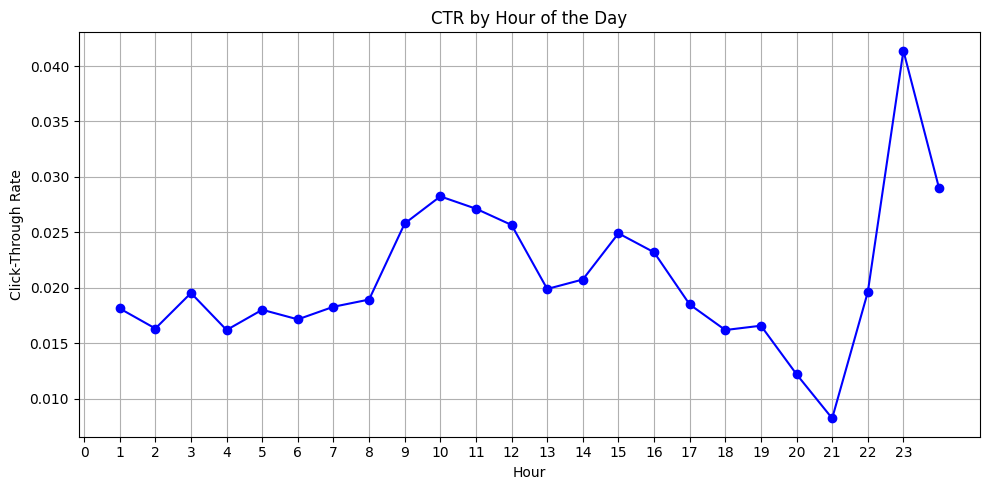

In [66]:
# CTR by hour
ctr_by_hour = email_df.groupby("hour")["clicked"].mean().reset_index()
ctr_by_hour.columns = ["hour", "CTR"]

print(ctr_by_hour)

# Plot CTR by hour
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(ctr_by_hour["hour"], ctr_by_hour["CTR"], marker='o', linestyle='-', color='blue')
plt.title("CTR by Hour of the Day")
plt.xlabel("Hour")
plt.ylabel("Click-Through Rate")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

The **highest** click-through rate (CTR) occurs at **11 PM**, with a peak of 4.14%, followed by strong performance around midnight (2.90%) and the late morning hours of 10 AM (2.82%) and 11 AM (2.71%). This indicates that the best times to send emails are at 11 PM and late morning (10–12 AM) when user engagement is at its highest.